# BWW Challenge Level 3 - Getting started!                     

Welcome to the 2022 Better Working World Data Challenge!

This notebook will show you how to open and explore the data, create a basic solution of the problem, and submit your results.

Prior to running this notebook, make sure you have:

1. Created a profile on the EY Data Science Platform
2. Registered for BWW Challenge 2022 Level 3: "Predict the density of frog population" on the platform. There are multiple data Catalogs available on Microsoft planetary portal which can be used while building the frog density model i.e. Sentinel L2, JRC Global Surface Water, TerraClimate etc.  

# Level 3: Regression model – Predict the density of frog population 

## To Do Task

Build a combined Regression model to predict the density of frog population for regions covering **Australia , South Africa and Costa Rica**. 

There are multiple data Catalogs available on Microsoft Planetary Computer portal which can be used while building the frog density model i.e. Sentinel-2 Level 2A, JRC Global Surface Water, TerraClimate etc (refer "Appendix" section).

Below code is provided for a sample model  built on entire Australia region by using Climatic variables as predictors and target variable from the FrogID dataset having frog presence details (GBIF portal). 

Participants **must include** frog presence datasets for the **time period Nov'2017 to Nov'2019** from Australia (frogID dataset), South Africa (iNaturalist Research-grade observations) and Costa Rica (iNaturalist Research-grade observations) to  build the **combined prediction model excluding Australia (State Province = "South Australia), South Africa (State Province = "Western Cape") and Costa Rica (State Province = "Puntarenas") from the respective datasets.**

**Model Accuracy Evaluation- An Out-of-sample validation dataset is provided to the contestants for predicting the frog density on the above excluded regions (South Australia, Western Cape & Puntarenas) respectively.**

**NOTE**:  In the Appendix, there are two examples of data extraction code for Sentinel L2 Catalog & JRC Water Surface Catalog available on Microsoft Planetary Portal to be used as a reference.

## Datasets used

#### 1. FrogID dataset - Australia
The dataset provides information about the presence of frogs across Australia over a period of 2 years from Nov'2017 to Nov'2019.


Data Source : [Global Biodiversity Information Facility](https://www.gbif.org/) portal.

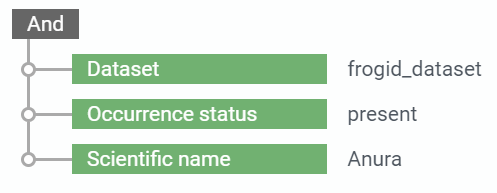

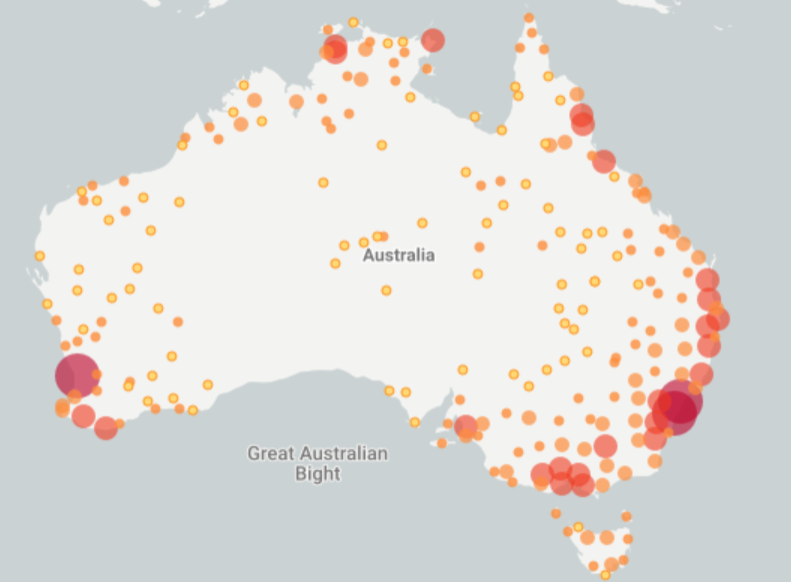

#### 2.  iNaturalist Research-grade observation dataset- South Africa & Costa Rica (2 years data from 2017-2019)

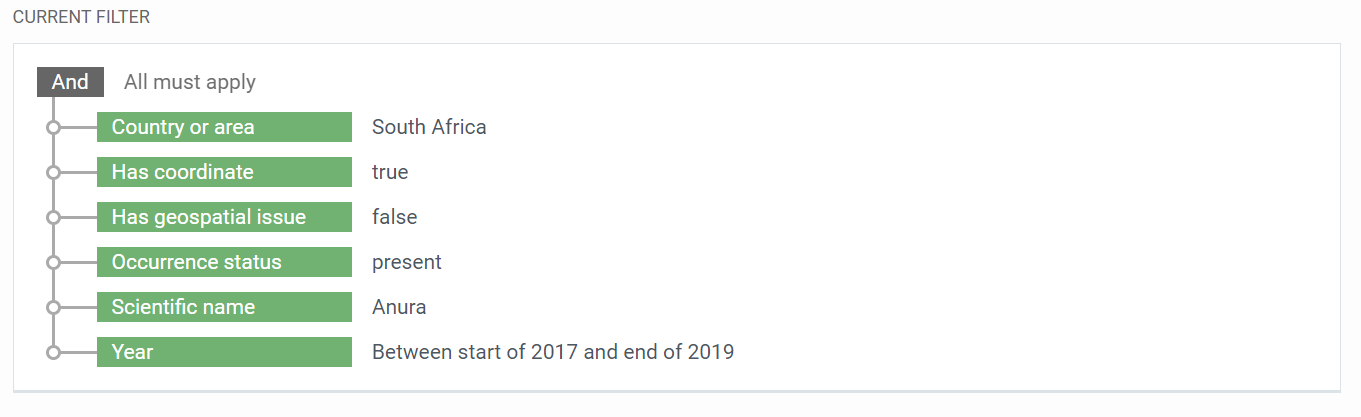

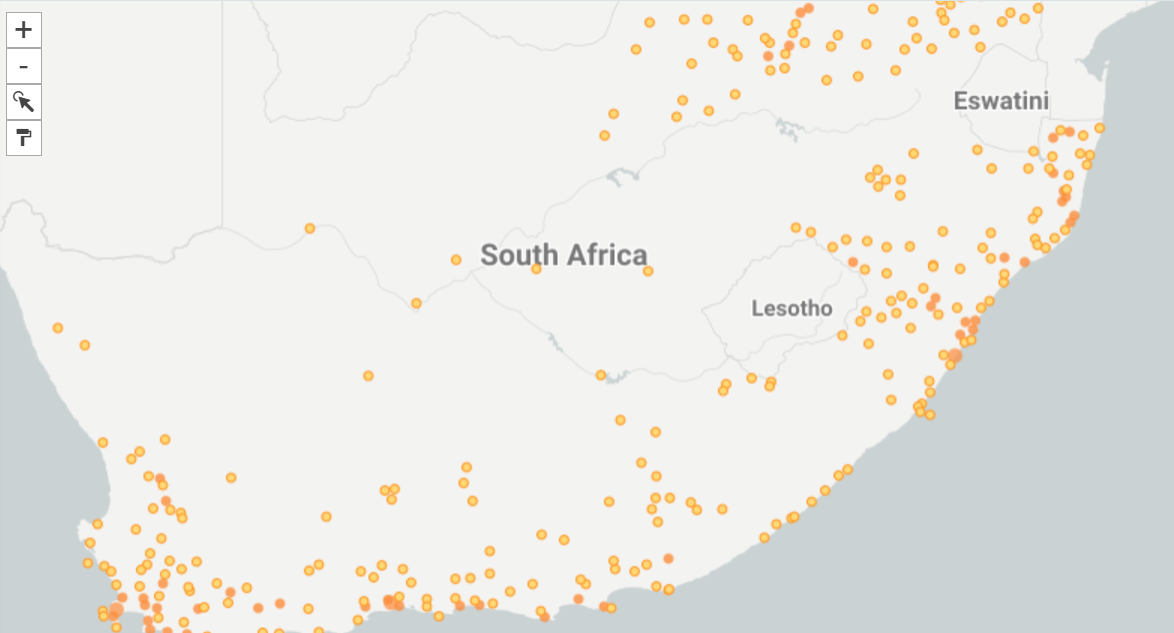

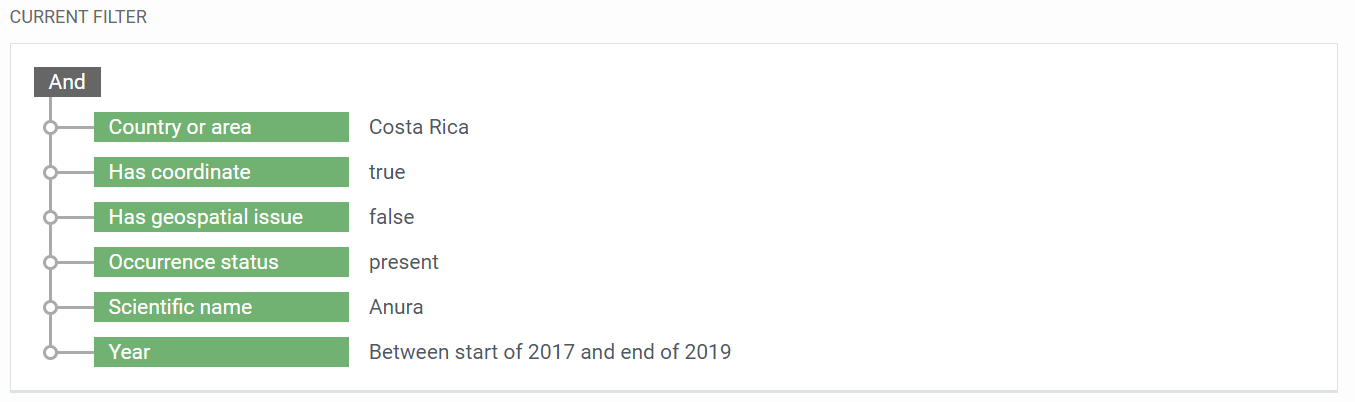

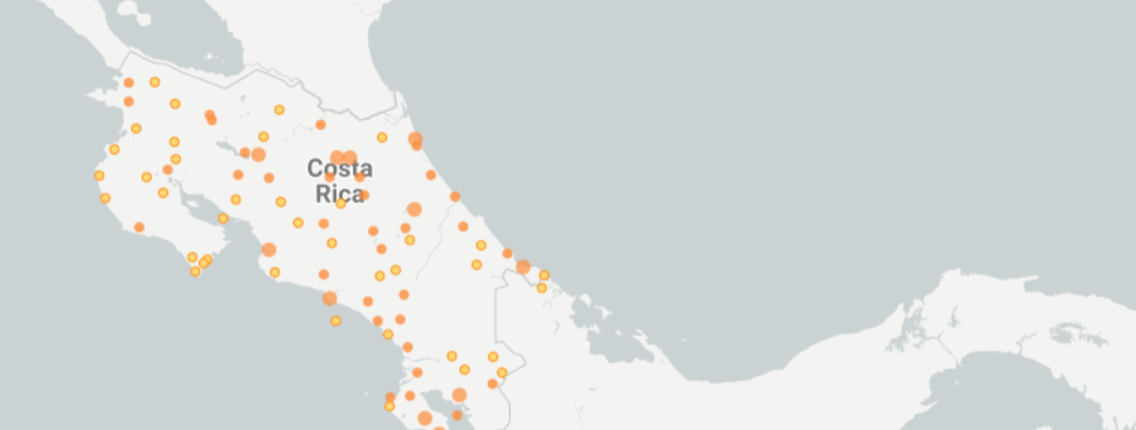

#### 3.  Climate Data 
TerraClimate data from Micorosoft Planetary catalog which provides monthly climate and climatic water balance for global terrestrial surfaces from 1958 to the present. The data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data.

Data Source : [Terraclimate dataset](https://planetarycomputer.microsoft.com/dataset/terraclimate) from the Microsoft Planetary Computer portal.

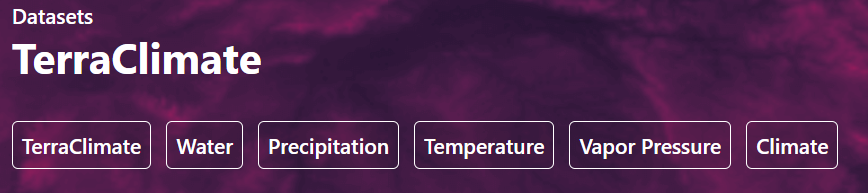
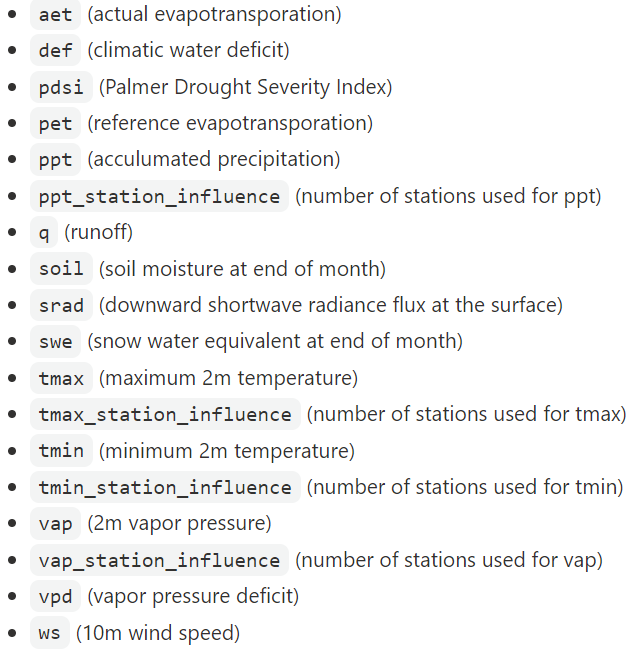

<br>
<br>


##  Import required Libraries

In [1]:
#Importing the necessary libraries
import pandas as pd
import pystac
import fsspec
import xarray as xr
import datetime 
import numpy as np
import math
from tqdm import tqdm
from datetime import date
import pystac
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import r2_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")

##   Load dataset

###  Loading TerraClimate data from Microsoft Planetary Data Catalog

In [2]:
# Extracting data from Planetary Computer Terra Climate catalog
url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate"
collection = pystac.read_file(url)
asset = collection.assets["zarr-https"]
store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:                 (time: 744, lat: 4320, lon: 8640, crs: 1)
Coordinates:
  * crs                     (crs) int16 3
  * lat                     (lat) float64 89.98 89.94 89.9 ... -89.94 -89.98
  * lon                     (lon) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
  * time                    (time) datetime64[ns] 1958-01-01 ... 2019-12-01
Data variables: (12/18)
    aet                     (time, lat, lon) float32 ...
    def                     (time, lat, lon) float32 ...
    pdsi                    (time, lat, lon) float32 ...
    pet                     (time, lat, lon) float32 ...
    ppt                     (time, lat, lon) float32 ...
    ppt_station_influence   (time, lat, lon) float32 ...
    ...                      ...
    tmin                    (time, lat, lon) float32 ...
    tmin_station_influence  (time, lat, lon) float32 ...
    vap                     (time, lat, lon) float32 ...
    vap_station_influence   (time, lat, lon) float32 ...
    vpd                     (time, lat, lon) float32 ...
    ws                      (time, lat, lon) float32 ...

In [3]:
import os 
os.chdir('/home/annaklumos/Projects/GitHub/EY-Challenge/')

### Loading the frog presence data

In [4]:
#Frog Presence data - 125621 records
path_frog_occur = "datasets/Australie.csv"
df_frog=pd.read_csv(path_frog_occur,usecols=['eventDate','year','month','decimalLatitude','decimalLongitude','occurrenceStatus',"stateProvince"])

print(df_frog.shape)
df_frog["eventDate"] = pd.to_datetime(df_frog["eventDate"])
df_frog.head()

(125621, 7)


occurrenceStatus  eventDate  year  month stateProvince  decimalLatitude  \
0          PRESENT 2017-11-14  2017     11           Vic            -38.1   
1          PRESENT 2017-11-25  2017     11           Qld            -26.7   
2          PRESENT 2018-01-03  2018      1           Nsw            -30.3   
3          PRESENT 2018-01-26  2018      1            Nt            -12.6   
4          PRESENT 2018-02-06  2018      2           Qld            -26.3   

   decimalLongitude  
0             144.6  
1             153.1  
2             152.9  
3             131.1  
4             152.9

## Grid based approach for extracting frog count 
#### For calculating the frog density over Australia, we will create a grid of 225 sq. kms then we will evaluate the frog presence points on each of the grid

### Australia region bbox

In [5]:
# Australia region bbox(excluding "Tasmania" region)
aus = {"type":"Polygon",
       "coordinates":[[[153.896484,-39.327584],[113.062499,-39.327584],
                       [113.062499,-10.521216],[153.896484,-10.521216],[153.896484,-39.327584]]]}
aus["coordinates"] = aus["coordinates"][0][0:4]
min_longi = min(aus["coordinates"])[0]
max_longi = max(aus["coordinates"])[0]
min_lati =  min(aus["coordinates"])[1]
max_lati = max(aus["coordinates"])[1]

print("min_lati = ",min_lati,"\n","min_longi = ",min_longi,"\n","max_lati = ",max_lati,"\n","max_longi = ",max_longi)

min_lati =  -39.327584 
 min_longi =  113.062499 
 max_lati =  -10.521216 
 max_longi =  153.896484


In [6]:
## Australia region bbox for "Tasmania" region
tas = {"type":"Polygon",
       "coordinates":[[[148.541748,-39.398856],[143.802246,-39.398856],
                       [143.802246,-43.69331],[148.541748,-43.69331],[148.541748,-39.398856]]]}
tas["coordinates"] = tas["coordinates"][0][0:4]

min_longi_tas = min(tas["coordinates"])[0]
max_longi_tas = max(tas["coordinates"])[0]
min_lati_tas =  min(tas["coordinates"])[1]
max_lati_tas = max(tas["coordinates"])[1]

print("min_lati = ",min_lati_tas,"\n","min_longi = ",min_longi_tas,"\n","max_lati = ",max_lati_tas,"\n","max_longi = ",max_longi_tas)

min_lati =  -43.69331 
 min_longi =  143.802246 
 max_lati =  -39.398856 
 max_longi =  148.541748


In [7]:
# Combining the whole of Australia including Tasmania region 
aus_whole = {"min_lati":min_lati_tas,"max_lati":max_lati,"min_longi":min_longi,"max_longi":max_longi}

### Grid formation

In [8]:
#Using grid based approach, creating 225 sq.kms grid, the approx. difference between lat-lon for 225 sq.kms area : lat is 0.1331 and lon is 0.15365 respectively
#66500 grids formulated for the entire region of Australia
bbox_grid_whole = [({"min_x":np.round(x,4), "min_y":np.round(y,4), "max_x":np.round(x + 0.15365,4),
                     "max_y":np.round(y + .1331,4)}) for x, y in itertools.product(np.arange(aus_whole["min_longi"], aus_whole["max_longi"],0.15365),
                                                                                   np.arange(aus_whole["min_lati"], aus_whole["max_lati"],.1331))]
print(len(bbox_grid_whole))

66500


###  Frog_count column formation of frog_id dataset

In [9]:
# Calculate the frog count (greater than 0) by iterating through each of the grid and subsetting frog presence data, 
#append to a dictionary with bounding box coordinates and shape of the subset data as - frog count
filt_lat = {}
i=1
for _,bbox in tqdm(enumerate(bbox_grid_whole)):  
    longi_lati_df_rang = df_frog[((df_frog['decimalLongitude'] >= bbox["min_x"]) & (df_frog['decimalLongitude'] <= bbox["max_x"])) & 
                           ((df_frog['decimalLatitude'] >= bbox["min_y"]) & (df_frog['decimalLatitude'] <=bbox["max_y"]))]
    if longi_lati_df_rang.shape[0]>0:
        filt_lat[i] ={}
        filt_lat[i]["coord"] = bbox
        filt_lat[i]["frog_count"] = longi_lati_df_rang.shape[0]
        i=i+1
aus_whole_filt_cord = filt_lat

66500it [01:11, 927.20it/s]


In [10]:
# Sample dictionary with bounding box and frog count
dict(list(aus_whole_filt_cord.items())[0:2])

{1: {'coord': {'min_x': 113.6771,
   'min_y': -24.9262,
   'max_x': 113.8307,
   'max_y': -24.7931},
  'frog_count': 1},
 2: {'coord': {'min_x': 114.138,
   'min_y': -27.7213,
   'max_x': 114.2917,
   'max_y': -27.5882},
  'frog_count': 8}}

In [11]:
# Converting the frog_id dictionary to dataframe having 2660 rows & 6 columns
aus_whole_filt_cord_df = pd.DataFrame.from_dict(aus_whole_filt_cord,orient="index")

aus_whole_filt_cord_df["min_lon"] = [i["min_x"] for i in aus_whole_filt_cord_df["coord"]]
aus_whole_filt_cord_df["min_lat"] = [i["min_y"] for i in aus_whole_filt_cord_df["coord"]]

aus_whole_filt_cord_df["max_lon"] = [i["max_x"] for i in aus_whole_filt_cord_df["coord"]]
aus_whole_filt_cord_df["max_lat"] = [i["max_y"] for i in aus_whole_filt_cord_df["coord"]]


print(aus_whole_filt_cord_df.shape)
aus_whole_filt_cord_df.head()

(2660, 6)


coord  frog_count   min_lon  \
1  {'min_x': 113.6771, 'min_y': -24.9262, 'max_x'...           1  113.6771   
2  {'min_x': 114.138, 'min_y': -27.7213, 'max_x':...           8  114.1380   
3  {'min_x': 114.599, 'min_y': -28.9192, 'max_x':...           3  114.5990   
4  {'min_x': 114.599, 'min_y': -28.7861, 'max_x':...          28  114.5990   
5  {'min_x': 114.599, 'min_y': -28.653, 'max_x': ...          35  114.5990   

   min_lat   max_lon  max_lat  
1 -24.9262  113.8307 -24.7931  
2 -27.7213  114.2917 -27.5882  
3 -28.9192  114.7526 -28.7861  
4 -28.7861  114.7526 -28.6530  
5 -28.6530  114.7526 -28.5199

### Averaging the terraclimate variables across the Grids

In [12]:
# Selecting time frame based on frogid dataset
ds_date = ds.sel(time = slice("2017-11-01","2019-11-01"))

# filtering data for Austrlia region based on coordinates
ds_aus = ds_date.where((ds.lat>=aus_whole["min_lati"]) & (ds.lat<=aus_whole["max_lati"]) & 
                       ((ds.lon>=aus_whole["min_longi"] ) & (ds.lon<=aus_whole["max_longi"])),drop = True)

#  Converting the xarray format to pandas dataframe 
ds_aus = ds_aus.to_dataframe().reset_index()

ds_aus["time"] = pd.to_datetime(ds_aus["time"])

In [13]:
# Iterate the Terra climate lat-lon across the grids for averaging the terraclimate values for a particular lat-Lon
for ind,row in tqdm(aus_whole_filt_cord_df.iterrows()):

    
    longi_lati_df_rang = ds_aus[(ds_aus['lon'] >= row["min_lon"]) & (ds_aus['lon'] <= row["max_lon"]) & 
                           (ds_aus['lat'] >= row["min_lat"]) & (ds_aus['lat'] <=row["max_lat"])]
    
    
    col = [{var:longi_lati_df_rang[var].mean()} for var in longi_lati_df_rang[longi_lati_df_rang.columns[4:]]]
    
    for var in col:
        for key,val in var.items():
#             print(key,val)
            aus_whole_filt_cord_df.loc[ind,key] = val
    
    aus_whole_filt_cord_df.loc[ind,"samples_count"] = longi_lati_df_rang.shape[0]

2660it [03:39, 12.14it/s]


In [14]:
# Shape of final dataset - (2660,25)
aus_whole_filt_cord_df.shape

(2660, 25)

## Data preprocessing for regression based model building

In [15]:
# Copying 'aus_whole_filt_cord_df' to new variable - 'df_aus_225_2yr'
df_aus_225_2yr = aus_whole_filt_cord_df.copy()
df_aus_225_2yr.head(2)

coord  frog_count   min_lon  \
1  {'min_x': 113.6771, 'min_y': -24.9262, 'max_x'...           1  113.6771   
2  {'min_x': 114.138, 'min_y': -27.7213, 'max_x':...           8  114.1380   

   min_lat   max_lon  max_lat        aet         def      pdsi         pet  \
1 -24.9262  113.8307 -24.7931  12.150000  181.350006 -2.382000  193.516663   
2 -27.7213  114.2917 -27.5882  17.793333  148.386673 -4.157999  166.083328   

   ...  swe       tmax  tmax_station_influence       tmin  \
1  ...  0.0  29.463333                     0.0  18.459324   
2  ...  0.0  28.077656                     0.0  14.859997   

   tmin_station_influence       vap  vap_station_influence       vpd  \
1                     0.0  1.465966                    0.0  1.715933   
2                     0.0  1.497400                    0.0  1.316767   

         ws  samples_count  
1  4.609332          300.0  
2  4.691668          300.0  

[2 rows x 25 columns]

In [16]:
# Data preprocessing

# selecting relevant columns and appending frog count column
sel_col = df_aus_225_2yr.columns[6:].to_list()
sel_col.extend(["frog_count"])
print(len(sel_col))

# delete the 'samples_count' column
df_model_data = df_aus_225_2yr[sel_col]
del df_model_data["samples_count"]
df_model_data.head(2)

20


aet         def      pdsi         pet        ppt  \
1  12.150000  181.350006 -2.382000  193.516663  12.783334   
2  17.793333  148.386673 -4.157999  166.083328  18.896667   

   ppt_station_influence         q      soil        srad  swe       tmax  \
1                    0.0  0.613333  1.320000  262.563324  0.0  29.463333   
2                    0.0  0.860000  6.053333  246.456665  0.0  28.077656   

   tmax_station_influence       tmin  tmin_station_influence       vap  \
1                     0.0  18.459324                     0.0  1.465966   
2                     0.0  14.859997                     0.0  1.497400   

   vap_station_influence       vpd        ws  frog_count  
1                    0.0  1.715933  4.609332           1  
2                    0.0  1.316767  4.691668           8

### Missing value 

In [17]:
# Checking for missing values % for respective variables
for col in df_model_data.columns:
    miss_value_number = df_model_data[col].isna().sum()
    mis = ((df_model_data[col].isna().sum())/df_model_data[col].shape[0])*100
    print("missing valuein {} : is {} ---> {}%".format(col,miss_value_number,mis))

missing valuein aet : is 5 ---> 0.18796992481203006%
missing valuein def : is 5 ---> 0.18796992481203006%
missing valuein pdsi : is 5 ---> 0.18796992481203006%
missing valuein pet : is 5 ---> 0.18796992481203006%
missing valuein ppt : is 5 ---> 0.18796992481203006%
missing valuein ppt_station_influence : is 0 ---> 0.0%
missing valuein q : is 5 ---> 0.18796992481203006%
missing valuein soil : is 5 ---> 0.18796992481203006%
missing valuein srad : is 5 ---> 0.18796992481203006%
missing valuein swe : is 5 ---> 0.18796992481203006%
missing valuein tmax : is 5 ---> 0.18796992481203006%
missing valuein tmax_station_influence : is 0 ---> 0.0%
missing valuein tmin : is 5 ---> 0.18796992481203006%
missing valuein tmin_station_influence : is 0 ---> 0.0%
missing valuein vap : is 5 ---> 0.18796992481203006%
missing valuein vap_station_influence : is 0 ---> 0.0%
missing valuein vpd : is 5 ---> 0.18796992481203006%
missing valuein ws : is 5 ---> 0.18796992481203006%
missing valuein frog_count : is 0 

In [18]:
# Revalidating missing values for "soil" variable
df_model_data[df_model_data["soil"].isna()]

aet  def  pdsi  pet  ppt  ppt_station_influence   q  soil  srad  swe  \
1527  NaN  NaN   NaN  NaN  NaN                    0.0 NaN   NaN   NaN  NaN   
1958  NaN  NaN   NaN  NaN  NaN                    0.0 NaN   NaN   NaN  NaN   
2053  NaN  NaN   NaN  NaN  NaN                    0.0 NaN   NaN   NaN  NaN   
2131  NaN  NaN   NaN  NaN  NaN                    0.0 NaN   NaN   NaN  NaN   
2362  NaN  NaN   NaN  NaN  NaN                    0.0 NaN   NaN   NaN  NaN   

      tmax  tmax_station_influence  tmin  tmin_station_influence  vap  \
1527   NaN                     0.0   NaN                     0.0  NaN   
1958   NaN                     0.0   NaN                     0.0  NaN   
2053   NaN                     0.0   NaN                     0.0  NaN   
2131   NaN                     0.0   NaN                     0.0  NaN   
2362   NaN                     0.0   NaN                     0.0  NaN   

      vap_station_influence  vpd  ws  frog_count  
1527                    0.0  NaN NaN          22  
1958                    0.0  NaN NaN           8  
2053                    0.0  NaN NaN           1  
2131                    0.0  NaN NaN           5  
2362                    0.0  NaN NaN           5

In [19]:
# Original shape of dataset
df_model_data.shape

(2660, 19)

In [20]:
# Dropping missing values and checking the final shape of data (2655,19)
df_model_data = df_model_data.dropna()
df_model_data.shape

(2655, 19)

### Outlier Capping

In [21]:
# Outliers capping for treating outliers
def outlier_capping(x):
    x = x.clip(upper = x.quantile(0.99))
    x = x.clip(lower = x.quantile(0.01))
    return x

df_model_data.iloc[:,0:-1]=df_model_data.iloc[:,0:-1].apply(lambda x: outlier_capping(x))

In [22]:
# Checking unique values for the below columns
df_model_data[["ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence"]].value_counts().reset_index(name='Count')

ppt_station_influence  vap_station_influence  tmax_station_influence  \
0                    0.0                    0.0                     0.0   

   tmin_station_influence  Count  
0                     0.0   2655

In [23]:
# Dropping columns with only 0 values in the weather data
df_model_data.drop(["ppt_station_influence","vap_station_influence","tmax_station_influence","tmin_station_influence"],
                   axis=1, inplace=True)

### Correlation Matrix

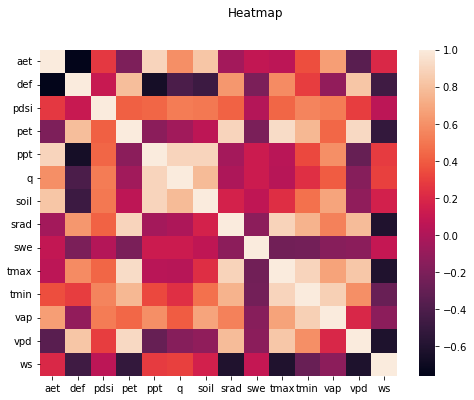

In [24]:
# Correlation matrix visualization
plt.figure(figsize=(8,6))
sns.heatmap(df_model_data.iloc[:,0:-1].corr())
plt.suptitle('Heatmap')
plt.show()

In [25]:
# Data distribution of column - 'swe'
df_model_data['swe'].value_counts()

0.000000    2577
1.042650      27
0.004444       4
0.010000       3
0.497500       2
0.013333       2
0.036667       2
0.587500       1
0.983333       1
0.390000       1
0.213333       1
0.080000       1
0.724444       1
0.096667       1
0.380000       1
0.112500       1
0.006667       1
0.470000       1
0.324444       1
1.004444       1
0.644444       1
0.351111       1
0.017500       1
0.050000       1
0.017778       1
0.676667       1
0.556667       1
0.056667       1
0.137500       1
0.536667       1
0.524444       1
0.886667       1
0.002500       1
0.593333       1
0.460000       1
0.020000       1
0.126667       1
0.146667       1
0.191111       1
0.875556       1
0.403333       1
0.076667       1
0.790000       1
0.016667       1
0.003333       1
Name: swe, dtype: int64

In [26]:
# Dropping column - 'swe' as most of the values are 0
df_model_data.drop(["swe"],axis = 1,inplace = True)

### Outlier treatment for Target variable 

<AxesSubplot:xlabel='frog_count'>

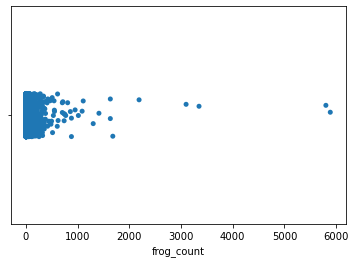

In [27]:
# Visulalisation for selecting the frog count
import seaborn as sns
sns.stripplot(df_model_data['frog_count'])

In [28]:
# Setting upper limit as less than 500 for frog count 
upper = 500
df_model_data = df_model_data[(df_model_data['frog_count'] < upper)]

## Model building

In [29]:
# Splitting the feature and target set to x and y
x = df_model_data.iloc[:,0:-1]
y = df_model_data["frog_count"].values

In [30]:
# Spliting the data into training and validation set based on 70-30 ratio
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [31]:
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1834, 13)
(1834,)
(787, 13)
(787,)


### Model normalization using minmaxscaler

In [32]:
# Data normalization using Minmaxscaler
mm_scaler = MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

### Multicollinearity treatment for predictor variables

In [33]:
# Generating VIF scores & dropping variables having high VIF to avoid multicollinearity
F = pd.DataFrame(X_train_mm,columns=x.columns).drop(['ppt','tmax','tmin','pet','def','srad'],axis=1)
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = F.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(F.values, i) for i in range(len(F.columns))]

print(vif_data)

  feature        VIF
0     aet  11.347598
1    pdsi   6.402008
2       q   3.894029
3    soil   8.692343
4     vap   8.158714
5     vpd   3.125524
6      ws   4.284884


In [34]:
# Dropping columns based on VIF score > 50
X_train_mm=pd.DataFrame(X_train_mm,columns=x.columns).drop(['ppt','tmax','tmin','pet','def','srad'],axis=1)
X_train_mm=X_train_mm.values
X_test_mm=pd.DataFrame(X_test_mm,columns=x.columns).drop(['ppt','tmax','tmin','pet','def','srad'],axis=1)
X_test_mm=X_test_mm.values

### Model checkpoint & building the architecture

In [35]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath='alternate_best_model_adam_225_2yr_updated_VIF.hdf5',
                             monitor='val_loss',verbose=1,save_weights_only=True,save_best_only=True,mode='min')

# model architecture for ANN model
model = Sequential()
model.add(Dense(512, activation="relu", input_dim=7))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="linear"))


# Compile model: The model is initialized with the Adam optimizer and then it is compiled
model.compile(loss='mean_squared_error', optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

# Patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=400)

# Fitting the model on train data
history = model.fit(X_train_mm, y_train, validation_data=(X_test_mm, y_test), epochs=10000, batch_size=128,
                    verbose=2, callbacks=[es,checkpoint])

Epoch 1/10000


2022-05-02 21:27:51.573951: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-02 21:27:51.574268: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 21:27:51.574840: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-02 21:27:51.706658: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-02 21:27:51.707096: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304005000 Hz


15/15 - 1s - loss: 4905.2749 - val_loss: 4367.3569

Epoch 00001: val_loss improved from inf to 4367.35693, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
Epoch 2/10000
15/15 - 0s - loss: 4415.0898 - val_loss: 3541.7100

Epoch 00002: val_loss improved from 4367.35693 to 3541.70996, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
Epoch 3/10000
15/15 - 0s - loss: 3959.9175 - val_loss: 3490.7788

Epoch 00003: val_loss improved from 3541.70996 to 3490.77881, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
Epoch 4/10000
15/15 - 0s - loss: 3873.6453 - val_loss: 3445.6467

Epoch 00004: val_loss improved from 3490.77881 to 3445.64673, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
Epoch 5/10000
15/15 - 0s - loss: 3834.7766 - val_loss: 3412.0251

Epoch 00005: val_loss improved from 3445.64673 to 3412.02515, saving model to alternate_best_model_adam_225_2yr_updated_VIF.hdf5
Epoch 6/10000
15/15 - 0s - loss: 3796.3916 - v

## Model Result & Analysis

In [36]:
# Validation Score by loading latest checkpoint saved
model.load_weights("alternate_best_model_adam_225_2yr_updated_VIF.hdf5")
PredTestSet = model.predict(X_test_mm)

# calculate train Rsquare
PredTrainSet = model.predict(X_train_mm)
train_R2 = r2_score(y_train, PredTrainSet)
print('train_R2:{}'.format(train_R2))

# calculate validate Rsquare
validation_R2 = r2_score(y_test, PredTestSet)
print('validation_R2:{}'.format(validation_R2))

train_R2:0.4955339894401042
validation_R2:0.38215769162360613


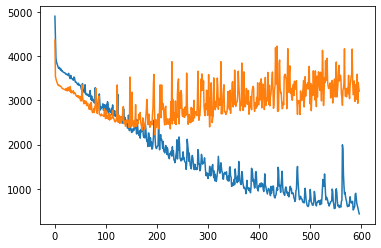

In [37]:
# Training loss vs Validation loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

###  1. Feature Importance

In [39]:
# Feature importance for model
import dalex as dx
explainer = dx.Explainer(model, X_train_mm, y_train, label='frog_count')
features = x.drop(['ppt','tmax','tmin','pet','def','srad'],axis=1).columns.to_list()
features

Preparation of a new explainer is initiated

  -> data              : numpy.ndarray converted to pandas.DataFrame. Columns are set as string numbers.
  -> data              : 1834 rows 7 cols
  -> target variable   : 1834 values
  -> model_class       : tensorflow.python.keras.engine.sequential.Sequential (default)
  -> label             : frog_count
  -> predict function  : <function yhat_tf_regression at 0x7f335c13dd30> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 3.58, mean = 28.0, max = 3.26e+02
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.49e+02, mean = 2.75, max = 3.67e+02
  -> model_info        : package tensorflow

A new explainer has been created!


['aet', 'pdsi', 'q', 'soil', 'vap', 'vpd', 'ws']

In [40]:
# Generating dict to identlfy the feature names in the below visualization
di = {}
i = 0
for each in features:
    di[i] = each
    i=i+1
di

{0: 'aet', 1: 'pdsi', 2: 'q', 3: 'soil', 4: 'vap', 5: 'vpd', 6: 'ws'}

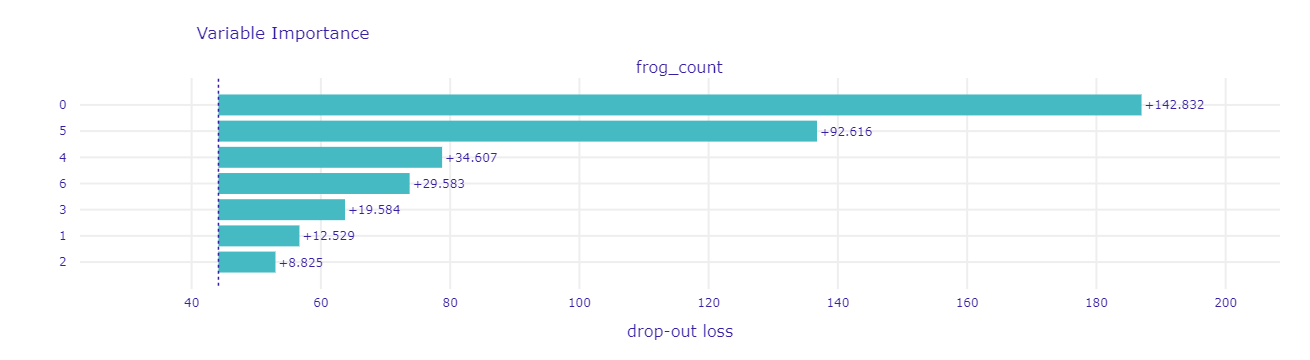

In [41]:
#plotting the variable importance chart
explainer.model_parts().plot()


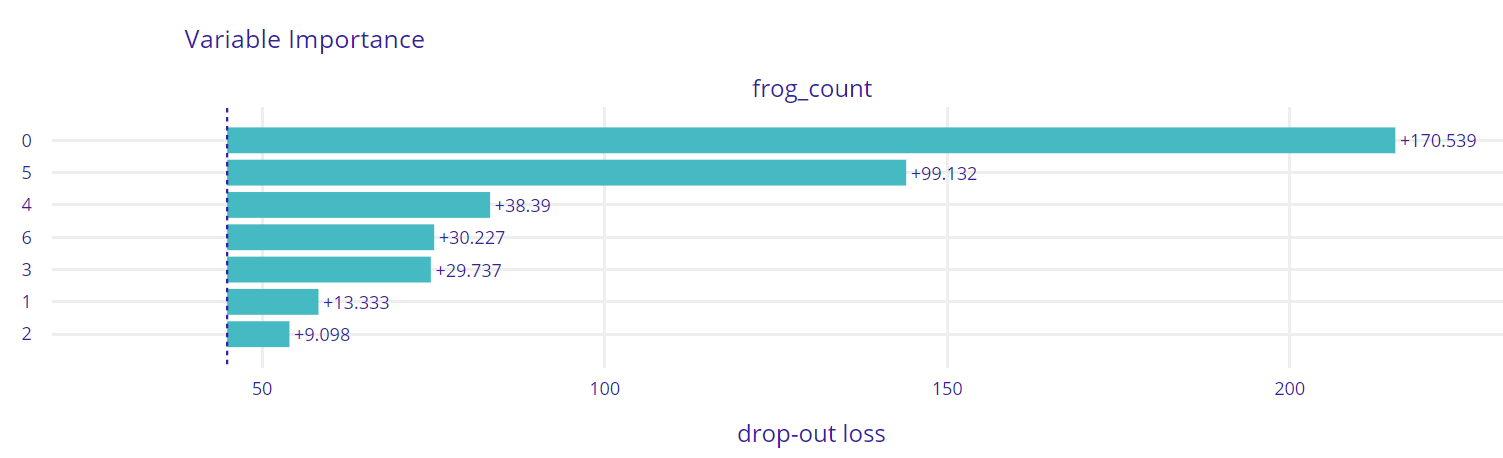 

## Saving model prediction into csv file

In [42]:
#prediction = pd.DataFrame(PredTestSet, columns=["prediction"])

# save the dataframe as a csv file (you may change the name of the csv file)
#prediction.to_csv("result.csv", index=False)

## Making a submission on the Platform

In [43]:
## An out-of-sample validation dataset has been provided for predicting the frog density on specified regions.
## Contestants should update the file with the predicted values & upload on the EY platform for evaluation. 

## Appendix
Here we have demonstrated the data extraction process for Sentinel-2 Level - 2A Catalog & JRC Water Surface Catalog from Microsoft Planetary Computers Portal. 

### 1. Sentinel-2 Level-2A

The Sentinel-2 program provides global imagery in thirteen spectral bands at 10m-60m resolution and a revisit time of approximately five days. This dataset represents the global Sentinel-2 archive, from 2016 to the present, processed to L2A (bottom-of-atmosphere) using Sen2Cor and converted to cloud-optimized GeoTIFF format.

Data Source : [Sentinel-2 Level-2A Dataset](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) from the Microsoft Planetary Computer portal.


#### Loading Sentinel-2 Image dataset

In [49]:
#Importing the required libraries
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Image processing
from scipy.ndimage import convolve

# Geospatial
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio as rio
import fsspec
# import xrspatial.multispectral as ms

# API
import requests
import json

# Import Planetary Computer
import stackstac
import pystac
import pystac_client
import planetary_computer


#### Gathering Data for Richmond, NSW

For this demonstration, we will constrain our search to frogs in the Richmond NSW area. 

In [50]:
# Richmond, NSW
min_lon, min_lat = (150.62, -33.69)  # Lower-left corner
max_lon, max_lat = (150.83, -33.48)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)


#### Fetching predictor variables
Next, we write a function called `get_pc` that will assist us in grabbing Sentinel Image from the planetary computer. It will calculate the median mosaic and return it as an xarray object.

In [51]:
# Function to access the planetary computer
def get_pc(product, bbox, assets={"image/tiff"}, resolution=10, pc_query=None, date_range=None, na_val=None, features=None):
    """Return the median mosaic xarray of a specified planetary computer product for a given location"""
    
    # Query the planetary computer
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        bbox=bbox,
        datetime=date_range,
        collections=[product],
        limit=500,  # fetch items in batches of 500
        query=pc_query
    )
    items = list(search.get_items())
    print('This is the number of scenes that touch our region:',len(items))
    signed_items = [planetary_computer.sign(item).to_dict() for item in items]

    # Define the scale according to our selected crs, so we will use degrees
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 
        
    # Stack up the items returned from the planetary computer
    data = (
        stackstac.stack(
            signed_items,
            epsg=4326, # Use common Lat-Lon coordinates
            resolution=scale, # Use degrees for crs=4326
            bounds_latlon = bbox,
            resampling=rio.enums.Resampling.average, # Average resampling method (only required when resolution >10)
            chunksize=4096,
            assets=assets
        )
    )
    
    if na_val is not None:
        data = data.where(lambda x: x != na_val, other=np.nan)
    
    # Median Composite
    median = data.median(dim="time", skipna=True).compute()
    return median

In [52]:
# Fetching sentinel images based on required parameters
data = get_pc(product='sentinel-2-l2a',
              bbox=bbox,
              assets=["B04", "B03", "B02", "B08"],
              resolution=100,
              pc_query={"eo:cloud_cover": {"lt": 20}},
              date_range="2020-01-01/2020-03-31",
              na_val=0)

This is the number of scenes that touch our region: 12


In [53]:
data

<xarray.DataArray 'stackstac-86725aa81ec0adfe0eab723445123748' (band: 4, y: 235, x: 234)>
array([[[ 434. ,  455.5,  273.5, ...,  739. ,  730.5,  707.5],
        [ 308.5,  372. ,  252. , ..., 1136. ,  770. ,  819.5],
        [ 288. ,  274.5,  297. , ...,  903.5,  949. ,  829. ],
        ...,
        [ 410. ,  400. ,  404. , ..., 1285.5, 1233. , 1287. ],
        [ 432.5,  401.5,  377. , ..., 1099.5, 1151. , 1128. ],
        [ 403. ,  362. ,  379.5, ..., 1013. , 1238. , 1104. ]],

       [[ 562.5,  545.5,  378. , ...,  731.5,  746.5,  741.5],
        [ 437. ,  474. ,  399. , ...,  892. ,  801. ,  776. ],
        [ 384.5,  412. ,  391.5, ...,  734.5,  821. ,  739. ],
        ...,
        [ 404. ,  407. ,  417. , ...,  994. ,  954.5,  991. ],
        [ 417.5,  392. ,  412. , ..., 1002.5, 1042. ,  995. ],
        [ 389. ,  375.5,  422.5, ...,  950. , 1101. , 1012.5]],

       [[ 412. ,  398. ,  273. , ...,  585. ,  541. ,  568. ],
        [ 289.5,  335. ,  270.5, ...,  709. ,  614. ,  626.5],
        [ 251.5,  278.5,  311. , ...,  589. ,  660.5,  610.5],
        ...,
        [ 325.5,  329.5,  332.5, ...,  818.5,  788.5,  821. ],
        [ 338.5,  310.5,  323.5, ...,  893.5,  885. ,  823. ],
        [ 325. ,  302. ,  331.5, ...,  846. ,  964.5,  908. ]],

       [[2539.5, 2341. , 1893.5, ..., 2083. , 2074. , 2678.5],
        [2170.5, 2167.5, 2242.5, ..., 2018. , 2381.5, 2100. ],
        [1877. , 2147. , 1917. , ..., 1828. , 2125.5, 2037.5],
        ...,
        [1752.5, 1828. , 1830.5, ..., 2202.5, 2131.5, 2283.5],
        [1677. , 1730.5, 1840. , ..., 2275. , 2209.5, 2113.5],
        [1688.5, 1680. , 1922.5, ..., 2211. , 2240.5, 2125.5]]])
Coordinates:
  * band                                     (band) <U3 'B04' 'B03' 'B02' 'B08'
  * x                                        (x) float64 150.6 150.6 ... 150.8
  * y                                        (y) float64 -33.48 ... -33.69
    s2:processing_baseline                   <U5 '02.12'
    sat:relative_orbit                       int64 30
    proj:epsg                                int64 32756
    sat:orbit_state                          <U10 'descending'
    s2:saturated_defective_pixel_percentage  float64 0.0
    constellation                            <U10 'Sentinel 2'
    s2:product_type                          <U7 'S2MSI2A'
    instruments                              <U3 'msi'
    s2:datatake_type                         <U8 'INS-NOBS'
    s2:degraded_msi_data_percentage          float64 0.0
    gsd                                      int64 10
    proj:shape                               object {10980}
    title                                    (band) <U20 'Band 4 - Red - 10m'...
    common_name                              (band) <U5 'red' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.665 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.038 ... 0.145
    epsg                                     int64 4326

It is possible to find the closest pixel using code similar to what is demonstrated below. Once this pixel is found, then the corresponding parameter data values can be used for modeling species distribution.Below is an example for a random Lat-Lon location.

In [54]:
# Provide longitude and latitude for x and y respectively
sentinel_var = data.sel(x=150.71, y=-33.51, method="nearest").values    
print("This is the Median Composite of Red, Green, Blue and NIR band values for the closest pixel: ", sentinel_var)

This is the Median Composite of Red, Green, Blue and NIR band values for the closest pixel:  [ 733.  712.  574. 2000.]


### 2. JRC Global Surface Water

Global surface water products from the European Commission Joint Research Centre, based on Landsat 5, 7, and 8 imagery. Layers in this collection describe the occurrence, change, and seasonality of surface water from 1984-2020. 

Data Source : [JRC Global Surface Water](https://planetarycomputer.microsoft.com/dataset/jrc-gsw) from the Microsoft Planetary Computer portal.

In [56]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Import common GIS tools
import numpy as np
import xarray as xr
import rasterio.features
import rasterio as rio
import rioxarray
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, Polygon
import fsspec
# import xrspatial.multispectral as ms

# Import Planetary Computer tools
import stackstac
import pystac
import pystac_client
import planetary_computer

# Plotting tools
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Table visualisation tools
import pandas as pd
from IPython.display import display, HTML

#### Gathering Data for Richmond, NSW

For this demonstration, we will constrain our search to frogs in the Richmond NSW area. 

In [57]:
# Richmond
min_lon, min_lat = (150.62, -33.69)  # Lower-left corner
max_lon, max_lat = (150.83, -33.48)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.
<br>The surface water data is an amalgamation of many thousands of timeseries images, so there is no need to query a timeframe or filter for cloud cover. (The change in time is captured in the `change` band, which quantifies the change in surface water between epoch 1984-1999 and epoch 2000-2019.)
<br>The result is one, clean scene for our region of interest.

In [58]:
# Execute a STAC API query for our selected area:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    collections=["jrc-gsw"]
)

items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))


This is the number of scenes that touch our region: 1


A single item is returned, so we can work with single assets. If we chose an area with multiple tiles intersecting, we could save use something like stacstack or gdal.BuildVRT to work with multiple items and assets as a single layer.

In [59]:
# Since theres only one scene
item = items[0]

Below extracts the bands that are available, as well as their descriptions. We save the asset keys in cog_assets so that we can reference them later.

In [60]:
# Extract asset info and store it in a table (purely for display purposes)
assets = pd.DataFrame()
for asset_key, asset in item.assets.items():
    if asset.media_type == pystac.MediaType.COG:
        asset_info = pd.DataFrame(asset.to_dict())
        asset_info['STAC Key'] = asset_key
        assets = assets.append(asset_info)
        
assets = assets.reset_index(drop=True)
assets = assets[['STAC Key', 'title', 'description']]
          
# Save asset keys to list
cog_assets = list(assets['STAC Key'])

# Truncate description for display
assets.description = assets.description.str.wrap(100)
display(HTML(assets.to_html().replace("\\n","<br>")))

Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then "clip" the data to only the pixels within our region (bounding box). We will keep all six bands. There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10-meters. This resolution can be easily changed below (e.g. 100 meters) to reduce the data volume of the final GeoTIFF output. This change may be neccesary when considering larger analysis regions. Also, we have selected a resampling method of "average" that will find the mean value of each band to create new pixels. This is only needed when the resolution is changed from 10-meters to larger values (e.g. 100 meters). 

In [61]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [62]:
data = (
    stackstac.stack(
        item,
        epsg=4326, # Use common Lat-Lon coordinates
        resolution=scale, # Use degrees for crs=4326
        bounds_latlon = bbox,
        # resampling=rasterio.enums.Resampling.average, # Average resampling method (only required when resolution >10)
        # assets=["extent"], 
        chunksize=4096,  
    )
    # .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    # .assign_coords(band=lambda x: x.title)  # use common names
)

In [63]:
data

<xarray.DataArray 'stackstac-3c60c88d22ddbfe4b65164b4a9d8a0a1' (time: 1, band: 6, y: 2339, x: 2339)>
dask.array<fetch_raster_window, shape=(1, 6, 2339, 2339), dtype=float64, chunksize=(1, 1, 2339, 2339), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2020-07-01
    id              (time) <U17 '150E_30Sv1_3_2020'
  * band            (band) <U11 'change' 'extent' ... 'transitions'
  * x               (x) float64 150.6 150.6 150.6 150.6 ... 150.8 150.8 150.8
  * y               (y) float64 -33.48 -33.48 -33.48 ... -33.69 -33.69 -33.69
    proj:bbox       object {-40.0, -30.0, 150.0, 160.0}
    proj:epsg       int64 4326
    proj:shape      object {40000}
    end_datetime    (band) object None None None ... '2020-12-31T11:59:59Z' None
    sci:citation    <U169 'Jean-Francois Pekel, Andrew Cottam, Noel Gorelick,...
    proj:transform  object {0.0, -0.00025, -30.0, 150.0, 0.00025}
    sci:doi         <U19 '10.1038/nature20584'
    start_datetime  (band) object None None None ... '2020-01-01T00:00:00Z' None
    description     (band) <U195 'Provides information on where surface water...
    title           (band) <U23 'Water Occurrence Change' ... 'Water Transiti...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(150.6199245418613, -33.6900826...
    crs:         epsg:4326
    transform:   | 0.00, 0.00, 150.62|\n| 0.00,-0.00,-33.48|\n| 0.00, 0.00, 1...
    resolution:  8.983111749910169e-05

In [64]:
data = data.persist()

# Remove the time dimension, since there is only one item
data = data[0]

In [65]:
data

<xarray.DataArray 'stackstac-3c60c88d22ddbfe4b65164b4a9d8a0a1' (band: 6, y: 2339, x: 2339)>
dask.array<getitem, shape=(6, 2339, 2339), dtype=float64, chunksize=(1, 2339, 2339), chunktype=numpy.ndarray>
Coordinates:
    time            datetime64[ns] 2020-07-01
    id              <U17 '150E_30Sv1_3_2020'
  * band            (band) <U11 'change' 'extent' ... 'transitions'
  * x               (x) float64 150.6 150.6 150.6 150.6 ... 150.8 150.8 150.8
  * y               (y) float64 -33.48 -33.48 -33.48 ... -33.69 -33.69 -33.69
    proj:bbox       object {-40.0, -30.0, 150.0, 160.0}
    proj:epsg       int64 4326
    proj:shape      object {40000}
    end_datetime    (band) object None None None ... '2020-12-31T11:59:59Z' None
    sci:citation    <U169 'Jean-Francois Pekel, Andrew Cottam, Noel Gorelick,...
    proj:transform  object {0.0, -0.00025, -30.0, 150.0, 0.00025}
    sci:doi         <U19 '10.1038/nature20584'
    start_datetime  (band) object None None None ... '2020-01-01T00:00:00Z' None
    description     (band) <U195 'Provides information on where surface water...
    title           (band) <U23 'Water Occurrence Change' ... 'Water Transiti...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(150.6199245418613, -33.6900826...
    crs:         epsg:4326
    transform:   | 0.00, 0.00, 150.62|\n| 0.00,-0.00,-33.48|\n| 0.00, 0.00, 1...
    resolution:  8.983111749910169e-05

In [66]:
# 6 bands in data
data.band.values

array(['change', 'extent', 'occurrence', 'recurrence', 'seasonality',
       'transitions'], dtype='<U11')

In [67]:
# Provide longitude and latitude for x and y respectively
data.sel(x=150.71, y=-33.51, method="nearest").values    

array([253.,   0.,   0.,   0.,   0.,   0.])